In [1]:
import os
import pickle
import pandas as pd 
import numpy as np

from ipynb.fs.defs.model import model_development, evaluate_predictions

import matplotlib.pyplot as plt 
import dataframe_image as dfi
import seaborn as sns 

from IPython.display import display_html 

from typing import List, Dict, Any, Optional

# ignore warnings
def warn(*args, **kwargs):
    pass

import warnings
warnings.warn = warn

## Pre-Processing
from sklearn.model_selection import train_test_split, KFold, cross_val_score #train/test split & k-fold cross validation
from sklearn.preprocessing import StandardScaler #scaler
from sklearn.decomposition import PCA #principle component analysis
from sklearn.impute import KNNImputer #impute missing data

# Load Pickle
away_model_file = 'away_finalized_stacked_model.sav'
home_model_file = 'home_finalized_stacked_model.sav'
home_model = pickle.load(open(away_model_file, 'rb'))
away_model = pickle.load(open(home_model_file, 'rb'))

# Models
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC, SVC

## Scoring 
from sklearn import metrics
from sklearn.metrics import confusion_matrix

# Data Import 
path = '/Users/rschraeder/Desktop/Projects/StanleyCupPredictions/data/'
classification_df = pd.read_csv(os.path.join(path, 'encoded_variables.csv'))
stanley_cup_df = pd.read_csv(os.path.join(path, 'stanley_cup.csv'))
stanley_cup_categorical = pd.read_csv(os.path.join(path, 'categorical_teams_set_cup.csv'))

## Summary & Testing on Future Games

The model is extremely accurate after adding in a decision tree classifier prior to stacking with the super-learner SVM. The assessment of the model determines that every prediction is an exact match of the original data, indicating it performs flawlessly upon the data for which it was trained. We can take a look at the Avalanche Vs. Lightning matchup to best understand how the algorithm may have performed in their past games, then test the capability of the model to predict new input data by using this year's Stanley Cup Final schedule among the Avalanche and Lightning. 

Based upon prior data, the Colorado Avalanche have defeated their Stanley Cup Final opponents the Tampa Bay Lightning during the regular season at home and away. We can simulate the Stanley Cup Final with the orientation it is scheduled: 

- Game 1 : 2022-06-15 Away: Lightning
- Game 2 : 2022-06-18 Away: Lightning
- Game 3 : 2022-06-20 Away: Avalanche
- Game 4 : 2022-06-22 Away: Avalanche
- Game 5 : 2022-06-24 Away: Lightning
- Game 6 : 2022-06-26 Away: Lightning


# After testing on the Stanley Cup

### Issues
I noticed an issue with overfitting potentially when the correlation matrix performed 100% accurate on test data and was fairly accurate when compared to real-world games for the Stanley Cup.

### Resolution
- I imputed values with means in the original data
- dropped goal amounts and categorical variables like team names and encoded team names where there were home and away
- split predictions to two separate models to predict away & home outcomes separately. 
- I converted all values to a rounded integer and ensured my output or target variables were simple whole numbers (i.e. not 1.0 or 0.0). 
- I changed the date column to a classifiable feature of day of the week as an integer to avoid time-series implications.
- Added features for total goals scored by a team

### Next Steps
- By dropping the goal amounts per game, I can use feature importance to deduce the importance of those variables especially by seeing the decline in accuracy afterward. Dropping them to see if that makes a difference was successful, but I should also try permutation importance for other variables, then select those of most impact. 
- Using a reliable method of stats over time and not getting rid of time-series data might be useful. In other words, trying a rolling average for each statistic if possible might help to overcome having an overall team-summary from the regular season represented as its stats. Having a history of stats would be most conducive to team growth and how they perform


In [2]:
# Game Outcome Predictors 

x = classification_df.loc[:, (classification_df.columns != 'outcome') & (classification_df.columns != 'home_wins')]
y_away = classification_df['outcome'] # predicting away wins
y_home = classification_df['home_wins'] # predicting home wins

# Impute missing values 
# imputer = KNNImputer(n_neighbors=2)
# x = imputer.fit_transform(x)
# y = imputer.fit_transform(y)

# Creating the Train and Test Split

# Use a train and test split for initial training & testing
x_away_train, x_away_test, y_away_train, y_away_test = train_test_split(x, y_away, test_size=0.30, random_state=42)
x_home_train, x_home_test, y_home_train, y_home_test = train_test_split(x, y_home, test_size=0.30, random_state=42)


In [13]:
# Training and Implementing the Stacking Model

## Pass in the models we wish to stack 

models = model_development.ensemble(
    names =  ['logistic_regression', 'kernel_svm', 'decision_tree'],
    models =  [
        LogisticRegression(),
        SVC(kernel='rbf', gamma=0.05),
        DecisionTreeClassifier()
    ]
)

# AWAY 
away_summary = model_development.evaluate_ensemble(models, x_away_train, y_away_train, x_away_test)
away_summary = pd.DataFrame.from_records(away_summary)

# HOME
home_summary = model_development.evaluate_ensemble(models, x_home_train, y_home_train, x_home_test)
home_summary = pd.DataFrame.from_records(home_summary)

cv = KFold(n_splits=5, random_state=0, shuffle=True)

def styler(df1, df2):
    """ SOURCE: https://www.thiscodeworks.com/display-two-dataframes-side-by-side-html-pandas-python-visualization/619285b06f88d700157a60d7 """
    
    df1_styler = df1.style.set_table_attributes("style='display:inline'").set_caption('Away Team Model')
    df2_styler = df2.style.set_table_attributes("style='display:inline'").set_caption('Home Team Model')
    return display_html(df1_styler._repr_html_() + df2_styler._repr_html_(), raw=True)

away_summary['stacked_linear_svm'] = [
    cross_val_score(away_model, x_away_train, y_away_train, scoring='accuracy', cv=cv).mean(), 
    cross_val_score(away_model, x_away_train, y_away_train, scoring='precision', cv=cv).mean(), 
    cross_val_score(away_model, x_away_train, y_away_train, scoring='recall', cv=cv).mean()   
]
home_summary['stacked_linear_svm'] = [
    cross_val_score(home_model, x_home_train, y_home_train, scoring='accuracy', cv=cv).mean(), 
    cross_val_score(home_model, x_home_train, y_home_train, scoring='precision', cv=cv).mean(), 
    cross_val_score(home_model, x_home_train, y_home_train, scoring='recall', cv=cv).mean()   
]
dfi.export(away_summary, '../../images/v2_stanley_cup_stackedmodel_performance_away.png')
dfi.export(home_summary, '../../images/v2_stanley_cup_stackedmodel_performance_home.png')

styler(away_summary, home_summary)

[0624/105830.957538:INFO:headless_shell.cc(660)] Written to file /tmp/tmp2jpj7wdz/temp.png.
[0624/105831.631451:INFO:headless_shell.cc(660)] Written to file /tmp/tmptgc7a71g/temp.png.


,decision_tree,kernel_svm,logistic_regression,stacked_linear_svm
Accuracy,0.521686,0.531398,0.588978,0.562932
Precision,0.475183,0.504851,0.569942,0.543385
Recall,0.475771,0.414468,0.531547,0.490406
,decision_tree,kernel_svm,logistic_regression,stacked_linear_svm
Accuracy,0.518484,0.531398,0.588978,0.564007
Precision,0.548436,0.552457,0.608240,0.578663
Recall,0.552857,0.638910,0.643984,0.652171


In [4]:
# Generating Predictions from the Stacked Model
# Predictions will favor the away team (1: Win, 0: Loss)

stanley_cup_categorical['predicted_away_outcome'] = model_development.predict(away_model, x)
stanley_cup_categorical['predicted_home_outcome'] = model_development.predict(home_model, x)

away = pd.DataFrame({
    'Predicted': stanley_cup_categorical.predicted_away_outcome.value_counts(),
    'Actual': stanley_cup_categorical.outcome.value_counts()
})

home = pd.DataFrame({
    'Predicted': stanley_cup_categorical.predicted_home_outcome.value_counts(),
    'Actual': stanley_cup_categorical.home_wins.value_counts()
})

styler(away, home)

,Predicted,Actual
0.000000,528,710
1.000000,790,608
,Predicted,Actual
0.000000,788,608
1.000000,530,710


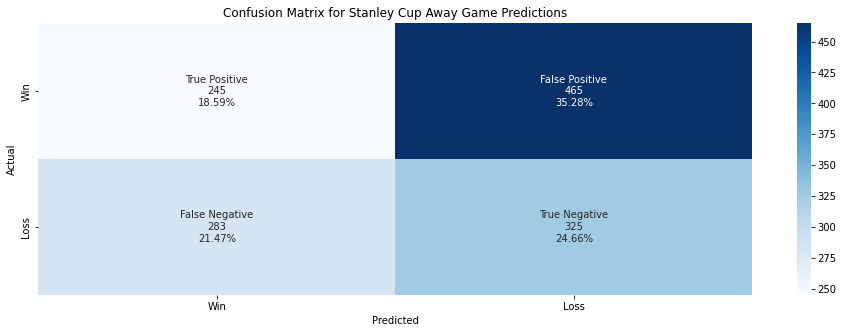

In [5]:
# Assessing Output Predictions
"""
Per the classification of the categorical game outcome, predictions are: 
- _*Home Win*_ : 0
- _*Away Win*_ : 1

The confusion matrix will show the: 
- True Positives
- False Positives
- True Negatives
- False Negatives
"""

away_conf_matrix = confusion_matrix(stanley_cup_categorical['outcome'], stanley_cup_categorical['predicted_away_outcome'])
home_conf_matrix = confusion_matrix(stanley_cup_categorical['home_wins'], stanley_cup_categorical['predicted_home_outcome'])

plt.figure(figsize=(16, 5))

def matrix_plot_labels(matrix):
    group_names = ['True Positive', 'False Positive', 'False Negative', 'True Negative']

    counts = ["{0:0.0f}".format(value) for value in matrix.flatten()]
    percentage = ["{0:.2%}".format(value) for value in matrix.flatten()/np.sum(matrix)]

    labels = [f"{i}\n{j}\n{k}" for i, j, k in zip(group_names, counts, percentage)]
    labels = np.asarray(labels).reshape(2,2)

    return labels

ax = sns.heatmap(away_conf_matrix, annot=matrix_plot_labels(away_conf_matrix), cmap='Blues', fmt='')
ax.set_title('Confusion Matrix for Stanley Cup Away Game Predictions')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.xaxis.set_ticklabels(['Win', 'Loss'])
ax.yaxis.set_ticklabels(['Win', 'Loss'])

plt.savefig('../../images/v2_confusion_matrix_stanley_cup_away.png')

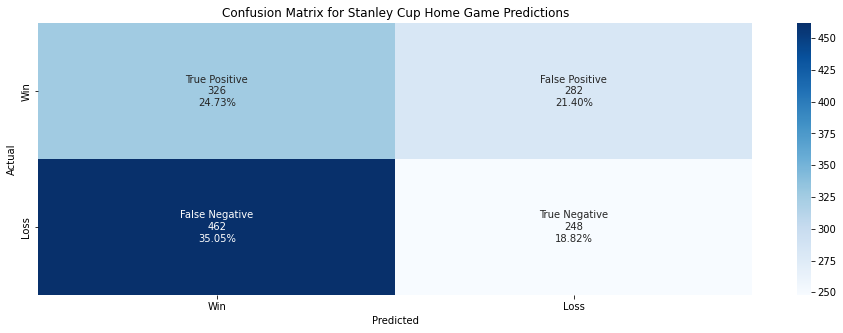

In [6]:
plt.figure(figsize=(16, 5))
ax = sns.heatmap(home_conf_matrix, annot=matrix_plot_labels(home_conf_matrix), cmap='Blues', fmt='')
ax.set_title('Confusion Matrix for Stanley Cup Home Game Predictions')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.xaxis.set_ticklabels(['Win', 'Loss'])
ax.yaxis.set_ticklabels(['Win', 'Loss'])

plt.savefig('../../images/v2_confusion_matrix_stanley_cup_home.png')

In [7]:
preds_df = stanley_cup_categorical[['date', 'away_team', 'home_team', 'predicted_away_outcome', 'predicted_home_outcome', 'outcome', 'home_wins']].rename(columns={'outcome': 'away_result', 'home_wins': 'home_result'})
preds_df.predicted_away_outcome = preds_df.predicted_away_outcome.apply(lambda x: 'Win' if x == 1 else 'Loss')
preds_df.predicted_home_outcome = preds_df.predicted_home_outcome.apply(lambda x: 'Win' if x == 1 else 'Loss')
preds_df.home_result = preds_df.home_result.apply(lambda x: 'Win' if x == 1 else 'Loss')
preds_df.away_result = preds_df.away_result.apply(lambda x: 'Win' if x == 1 else 'Loss')
preds_df

,date,away_team,home_team,predicted_away_outcome,predicted_home_outcome,away_result,home_result
0,2021-10-12,Pittsburgh Penguins,Tampa Bay Lightning,Win,Loss,Win,Loss
1,2021-10-14,Pittsburgh Penguins,Florida Panthers,Win,Loss,Loss,Win
2,2021-11-09,Pittsburgh Penguins,Chicago Blackhawks,Win,Loss,Loss,Win
3,2021-11-13,Pittsburgh Penguins,Ottawa Senators,Loss,Win,Loss,Win
4,2021-11-14,Pittsburgh Penguins,Washington Capitals,Loss,Win,Loss,Win
...,...,...,...,...,...,...,...
1313,2022-04-14,New Jersey Devils,Colorado Avalanche,Win,Loss,Loss,Win
1314,2022-04-16,New Jersey Devils,Seattle Kraken,Win,Loss,Loss,Win
1315,2022-04-18,New Jersey Devils,Vegas Golden Knights,Win,Loss,Win,Loss
1316,2022-04-26,New Jersey Devils,Ottawa Senators,Win,Loss,Loss,Win


In [8]:

avs_away_games = preds_df[preds_df['away_team']=='Colorado Avalanche']
avscorrect = len(avs_away_games[avs_away_games.predicted_away_outcome == avs_away_games.away_result]) # accurate predictions
avsincorrect = len(avs_away_games[avs_away_games.predicted_away_outcome != avs_away_games.away_result]) # innaccurate predictions

avs_home_games = preds_df[preds_df['home_team']=='Colorado Avalanche']
avs_home_correct = len(avs_home_games[avs_home_games.predicted_home_outcome == avs_home_games.home_result]) # accurate predictions
avs_home_incorrect = len(avs_home_games[avs_home_games.predicted_home_outcome != avs_home_games.home_result]) # innaccurate predictions

away_correct = len(preds_df[preds_df.predicted_away_outcome == preds_df.away_result]) # accurate predictions
away_incorrect = len(preds_df[preds_df.predicted_away_outcome != preds_df.away_result]) # innaccurate predictions

home_correct = len(preds_df[preds_df.predicted_home_outcome == preds_df.home_result]) # accurate predictions
home_incorrect = len(preds_df[preds_df.predicted_home_outcome != preds_df.home_result]) # innaccurate predictions


In [9]:
# Avalanche Away Games 

evaluate_predictions(avs_away_games, avscorrect, avsincorrect)

{'Correct Predictions': 20, 'Incorrect Predictions': 23, 'Overall Correct': '46.51162790697674%'}


In [10]:
# Avalanche Home Games 

evaluate_predictions(avs_home_games, avs_home_correct, avs_home_incorrect)

{'Correct Predictions': 20, 'Incorrect Predictions': 25, 'Overall Correct': '44.44444444444444%'}


In [11]:
# Original Data 

evaluate_predictions(preds_df, away_correct, away_incorrect)
evaluate_predictions(preds_df, home_correct, home_incorrect)

{'Correct Predictions': 570, 'Incorrect Predictions': 748, 'Overall Correct': '43.24734446130501%'}
{'Correct Predictions': 574, 'Incorrect Predictions': 744, 'Overall Correct': '43.55083459787557%'}


In [12]:
stanley_cup = preds_df.sort_values('date', ascending=True).tail(6)
stanley_cup.drop(columns={'away_result', 'home_result'}, inplace=True)
stanley_cup['predicted_winner'] = ['Colorado Avalanche', 'Colorado Avalanche', 'Tampa Bay Lightning', 'Tampa Bay Lightning', 'Colorado Avalanche', 'Colorado Avalanche']

dfi.export(stanley_cup, '../../images/v2_stanley_cup_predictions.png')
stanley_cup


[0624/104615.317636:INFO:headless_shell.cc(660)] Written to file /tmp/tmprzrxpe17/temp.png.


,date,away_team,home_team,predicted_away_outcome,predicted_home_outcome,predicted_winner
410,2022-06-15,Tampa Bay Lightning,Colorado Avalanche,Loss,Win,Colorado Avalanche
411,2022-06-18,Tampa Bay Lightning,Colorado Avalanche,Loss,Win,Colorado Avalanche
988,2022-06-20,Colorado Avalanche,Tampa Bay Lightning,Loss,Win,Tampa Bay Lightning
989,2022-06-22,Colorado Avalanche,Tampa Bay Lightning,Loss,Win,Tampa Bay Lightning
412,2022-06-24,Tampa Bay Lightning,Colorado Avalanche,Loss,Win,Colorado Avalanche
413,2022-06-26,Tampa Bay Lightning,Colorado Avalanche,Loss,Win,Colorado Avalanche
